# Exploring Fire Incidents - Analysis and Report

## *Andrew Leung - Sunday October 27, 2019*

## Task 1: Data Cleaning and Descriptive statistics

In this first section I explored the fire set to look at how each recorded is filled in, are there nulls and inappropriate values. In addition, I explore whether variables should be grouped up and if derived variables need to be created to produce deeper insights into the data. This section contains the code and results for the exploratory analysis, data cleaning, preparations, summary descripives and visualizations for the fire incidents dataset.

In [1]:
#improt packages
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import re
import calendar

In [2]:
#load file - fire incidents
fire = pd.read_csv("Fire_Incidents.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (11,12,19,37,44,45,54,58) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Using the .info() function, we take a look at the fields in the dataset and their field types.

In [3]:
fire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509740 entries, 0 to 509739
Data columns (total 63 columns):
Incident Number                                 509740 non-null int64
Exposure Number                                 509740 non-null int64
Address                                         509506 non-null object
Incident Date                                   509740 non-null object
Call Number                                     509740 non-null int64
Alarm DtTm                                      509740 non-null object
Arrival DtTm                                    509702 non-null object
Close DtTm                                      509739 non-null object
City                                            508156 non-null object
Zipcode                                         436842 non-null float64
Battalion                                       509740 non-null object
Station Area                                    508931 non-null object
Box                                    

After examining the datatset, I determined that the padding "O" from the csv is not preserved, so I re-padded the Incident Number column

In [4]:
#pad Incident Number - restore Incident Number
fire["Incident Number"] = fire["Incident Number"].astype(str)

fire.loc[fire["Incident Number"].str.len()==7,: "Incident Number"] = fire.loc[fire["Incident Number"].str.len()==7,: "Incident Number"].apply(lambda x: x.str.zfill(8))

fire.loc[fire["Incident Number"].str.len()==7].shape

fire["Incident Number"] = fire["Incident Number"].astype(int)

Further examination of the fields led me to changing the Incident Date, Alarm DtTm, Arrival and Close fields to date time objects in order to derive insights about response times by the fire deparment. These also enabled the creation of a numerical month column, day of month column and day of week columns. These maybe useful as predictors later on.

In [5]:
fire["date_clean"] = pd.to_datetime(fire["Incident Date"], format="%m/%d/%Y")
fire['month'] = fire['date_clean'].apply(lambda x: x.month)

fire['Month2'] = fire['month'].apply(lambda x: calendar.month_abbr[x])
fire["day"]= fire['date_clean'].apply(lambda x: x.day)

fire["dow_num"] = fire["date_clean"].dt.dayofweek
fire["dow_cat"]= fire["date_clean"].dt.day_name()

fire["Alarm DtTm"] = pd.to_datetime(fire["Alarm DtTm"])
fire["Arrival DtTm"] = pd.to_datetime(fire["Arrival DtTm"])
fire["Close DtTm"] = pd.to_datetime(fire["Close DtTm"])

fire["arrival_lag"] = fire["Arrival DtTm"] - fire["Alarm DtTm"]
fire["arrival_lag"] = fire["arrival_lag"].apply(lambda x: x.total_seconds())

fire["duration"] = fire["Close DtTm"] - fire["Arrival DtTm"]
fire["duration"] = fire["duration"].apply(lambda x: x.total_seconds())




In [6]:
fire.loc[:,["duration", "arrival_lag"]].aggregate(['sum', 'min', 'max','mean'])

,duration,arrival_lag
sum,5.756946e+08,1.622361e+08
min,0.000000e+00,-6.052500e+04
max,2.937651e+06,8.642240e+05
mean,1.129475e+03,3.182960e+02


Next, Neighborhood Districts was examined. Since it was a categorical variable, we can do a group up and see which neighbourhoods had the most and least amount of incidents.

In [7]:
#min_max
fire["Neighborhood  District"].value_counts()

Tenderloin                        44019
Financial District/South Beach    40321
Mission                           40019
South of Market                   36265
Bayview Hunters Point             19563
Western Addition                  19056
Nob Hill                          16712
Pacific Heights                   13131
Sunset/Parkside                   12709
Hayes Valley                      12131
Castro/Upper Market               12067
Chinatown                         12018
Marina                            11532
North Beach                        9860
Potrero Hill                       9780
Outer Richmond                     8599
Russian Hill                       8469
West of Twin Peaks                 8339
Bernal Heights                     8223
Lakeshore                          7785
Haight Ashbury                     7219
Inner Sunset                       6884
Mission Bay                        6804
Excelsior                          6673
Outer Mission                      6476


In order to determine which incidents had an acutal fire, the "Primary Situation" field was parsed to find the string "fire". I also parsed the action numbers column which showed corresponding actions for each incident. I realized that the Primary Situation field could contain key words like "false alarm, no fire", leading to a miscount of incidents with actual fires. Therefore, I realized that parsing the Action Taken Primary field and code "11" for extinguish was a more accurate way to count incidents where fires actually ocurred.

A "fire" column was created with "1" indicating a fire occurred and "0" indicating a fire did not occur.

In [8]:
#of fires
fire["Primary Situation"].str.contains("fire").value_counts()

False    399669
True     110071
Name: Primary Situation, dtype: int64

In [9]:
fire["action_number"] = fire["Action Taken Primary"].str.extract('^(\d{1,2})')

In [10]:
#top 3 actions
pd.DataFrame(fire["action_number"].value_counts()).reset_index()

# 86: investigate, 63: restore fire alarm, 11: extinguish

,index,action_number
0,86,287546
1,63,28378
2,11,26965
3,00,22474
4,70,15036
...,...,...
62,15,9
63,13,7
64,91,5
65,1,2


In [11]:
#create fire dependent variable
fire.loc[fire['action_number'] == '11', 'fire'] = 1 
fire.loc[fire['action_number'] != '11', 'fire'] = 0 

In [12]:
#total number of actual fire occurances
fire["fire"].value_counts()

0.0    482775
1.0     26965
Name: fire, dtype: int64

I examined the Exposure Number field to see if multiple houses were commonly involved with incidents. However, the vast number of "0" values incidates that most incidents are not multi-building instances.

In [13]:
fire.loc[(fire["action_number"]=='11') & (fire["Area of Fire Origin"].isnull()==True),:].shape

(14157, 73)

In [14]:
fire.loc[(fire["action_number"]=='11')].groupby(["Neighborhood  District","action_number"])["Exposure Number"].sum()

Neighborhood  District          action_number
Bayview Hunters Point           11               0
Bernal Heights                  11               0
Castro/Upper Market             11               0
Chinatown                       11               0
Excelsior                       11               0
Financial District/South Beach  11               0
Glen Park                       11               0
Golden Gate Park                11               0
Haight Ashbury                  11               0
Hayes Valley                    11               1
Inner Richmond                  11               0
Inner Sunset                    11               0
Japantown                       11               0
Lakeshore                       11               0
Lincoln Park                    11               0
Lone Mountain/USF               11               1
Marina                          11               0
McLaren Park                    11               0
Mission                         11  

In [15]:
fire["Exposure Number"].value_counts()

0    509720
1        19
5         1
Name: Exposure Number, dtype: int64

The next I examined the City field for a possible dependent variable field for prediction of fire locations. It was observed that there were a mix of abbreviations and different spellings of the same city, so the names were cleaned and spaces were removed.

In [16]:
fire["City"].value_counts()

SF                 326345
San Francisco      166337
SFO                  7254
SAN FRANCISCO        3081
Presidio             1296
TI                   1139
PR                    819
Treasure Isla         564
Fort Mason            229
Yerba Buena           177
Hunters Point         172
YB                    156
DC                    139
FM                    136
HP                    129
Daly City              48
BN                     45
PRESIDIO               36
OAK                    24
Brisbane               10
Treasure Island         8
TREASURE ISLAND         6
AI                      3
FORT MASON              3
Name: City, dtype: int64

In [18]:
#clean names
fire["City"].replace(['SF','SFO','SAN FRANCISCO'],"San Francisco", inplace=True)
fire["City"].replace(['FORT MASON',"FM"],"Fort Mason", inplace=True)
fire["City"].replace(['TREASURE ISLAND','Treasure Isla','TI'],"Treasure Island", inplace=True)
fire["City"].replace(['YB'],"Yerba Buena", inplace=True)
fire["City"].replace(['DC'],"Daly City", inplace=True)
fire["City"].replace(['HP'],"Hunters Point", inplace=True)
fire["City"].replace(['PRESIDIO','PR'],"Presidio", inplace=True)
fire["City"].replace(['BN'],"Brisbane", inplace=True)
fire["City"] = fire["City"].astype(str)
#replace spaces
fire["City"] = fire["City"].apply(lambda x: re.sub("\s","_",x))


In [19]:
# check values again
fire["City"].value_counts()

San_Francisco      503017
Presidio             2151
Treasure_Island      1717
nan                  1584
Fort_Mason            368
Yerba_Buena           333
Hunters_Point         301
Daly_City             187
Brisbane               55
OAK                    24
AI                      3
Name: City, dtype: int64

A final modification was also made to clean the columns Structure Type and Structure Status. These columns were changed to categorical columns based on the 1-digit code found in each column. 

In [20]:
fire["stype"] = fire["Structure Type"].str.extract('^(\d{1})')
fire.loc[fire["stype"].isna(),"stype"]= '0'

fire["s_status"]=fire["Structure Status"].str.extract('^(\d{1})')
fire.loc[fire["s_status"].isna(),"s_status"]= '0'

## Task 1: Plots for Exploratory - Univariate, Bivariate and Multivariate Plots

In this next section, plots were used a primary tool as many of the variables in the dataset are categorical. These plots and crosstabs aimed to drive insights into possible predictors for actual fire occurances and where fires would occur.

One continuous variable was examined in "Suppression Units", however, the histogram shows that the majority of values are 0 with really small counts of other values. This variable did not suggest itself to be a good predictor of fires.

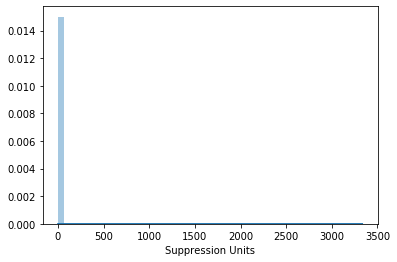

In [21]:
sns.distplot(fire["Suppression Units"])

The histogram of "City" showed that there City maybe a useful predictor for fire incidents as there seems to be a good deal of variablity. It was also observed that the San Francisco label was used for the majority of incidents, while these other city values are not necessarily cities, but districts in San Francisco. Therefore, the San Francisco label was removed from the histogram as it did not add any value. For the future, the neighbourhood filed and city fields should be reconciled and more clearly delineated.

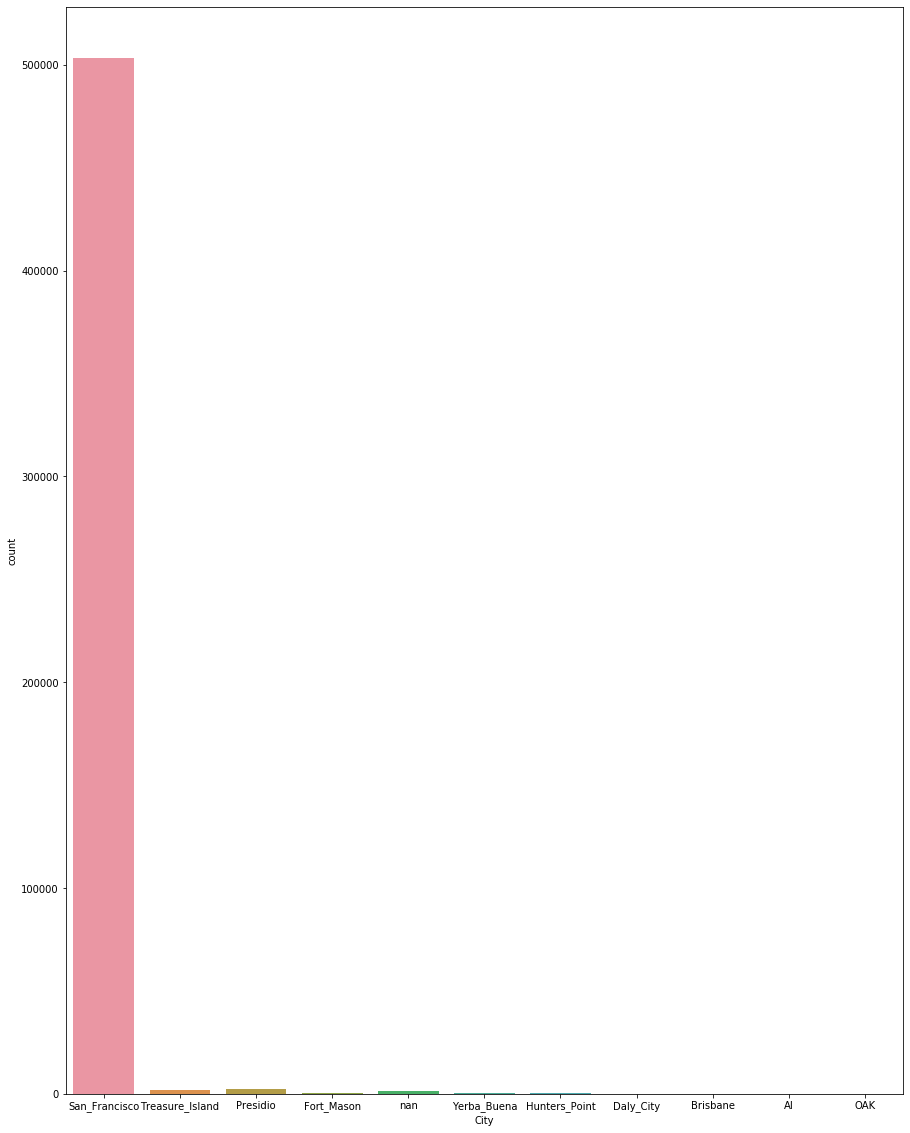

In [22]:
plt.figure(figsize = (15,20))
sns.countplot(fire.loc[fire["City"]!='San Francisco',"City"])

Here, we see the proportion of real fire occurances to non-fire occurances by City. These proportions indicate again that City should be a useful predictor column.

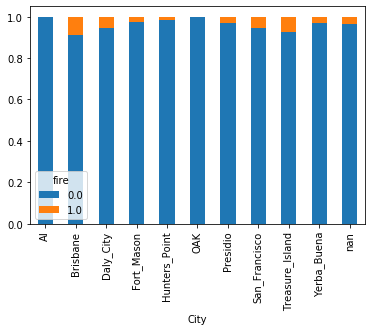

In [23]:
t = pd.crosstab(fire.loc[fire["City"]!='San Francisco',"City"],fire["fire"])
t.div(t.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

A plot of fire incidents by month by actual fire occurance shows that month may be helpful predictor of real fire incidents. The orange bars indicate the counts of actual fires at incidents in the given month.

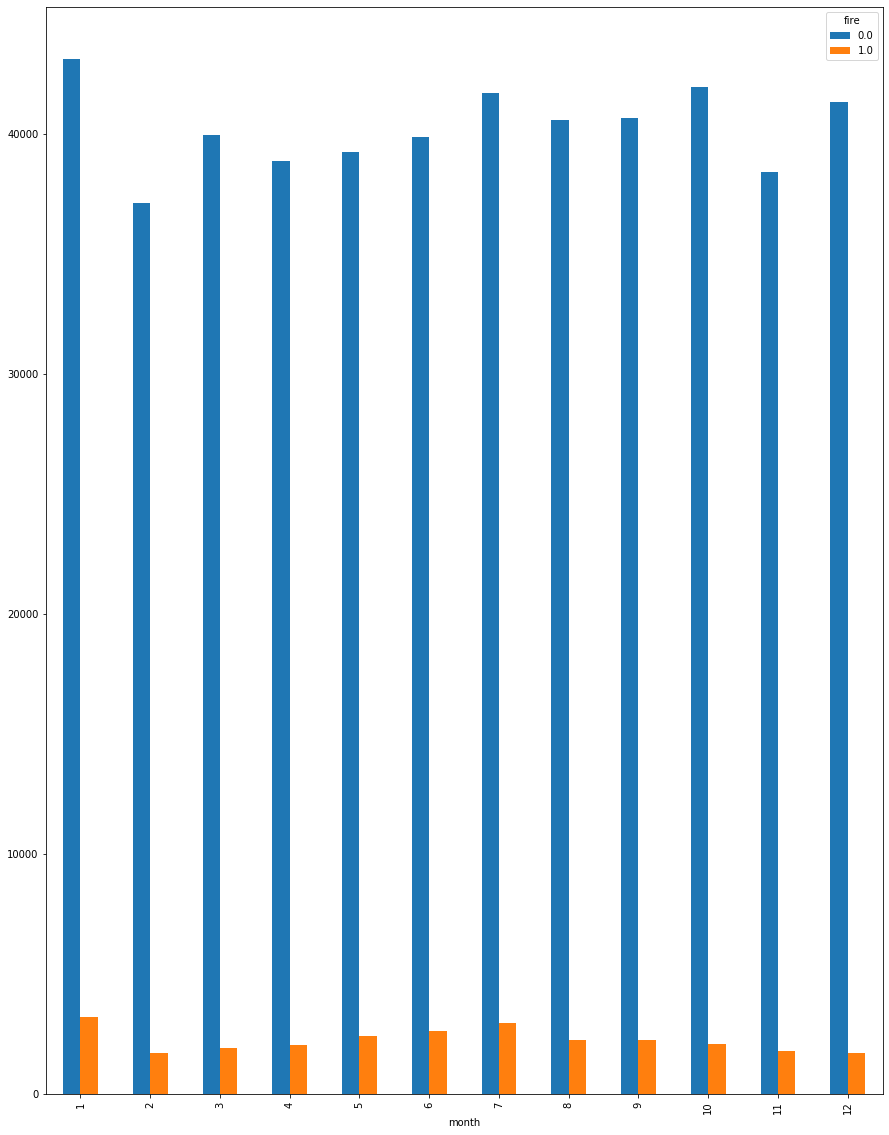

In [24]:
pd.crosstab(fire["month"],fire["fire"]).plot(kind='bar',figsize = (15,20))


Similarly, a plot of fire incident counts by day of month by actual occurance of fire shows that day of month may be a helpful predictor.

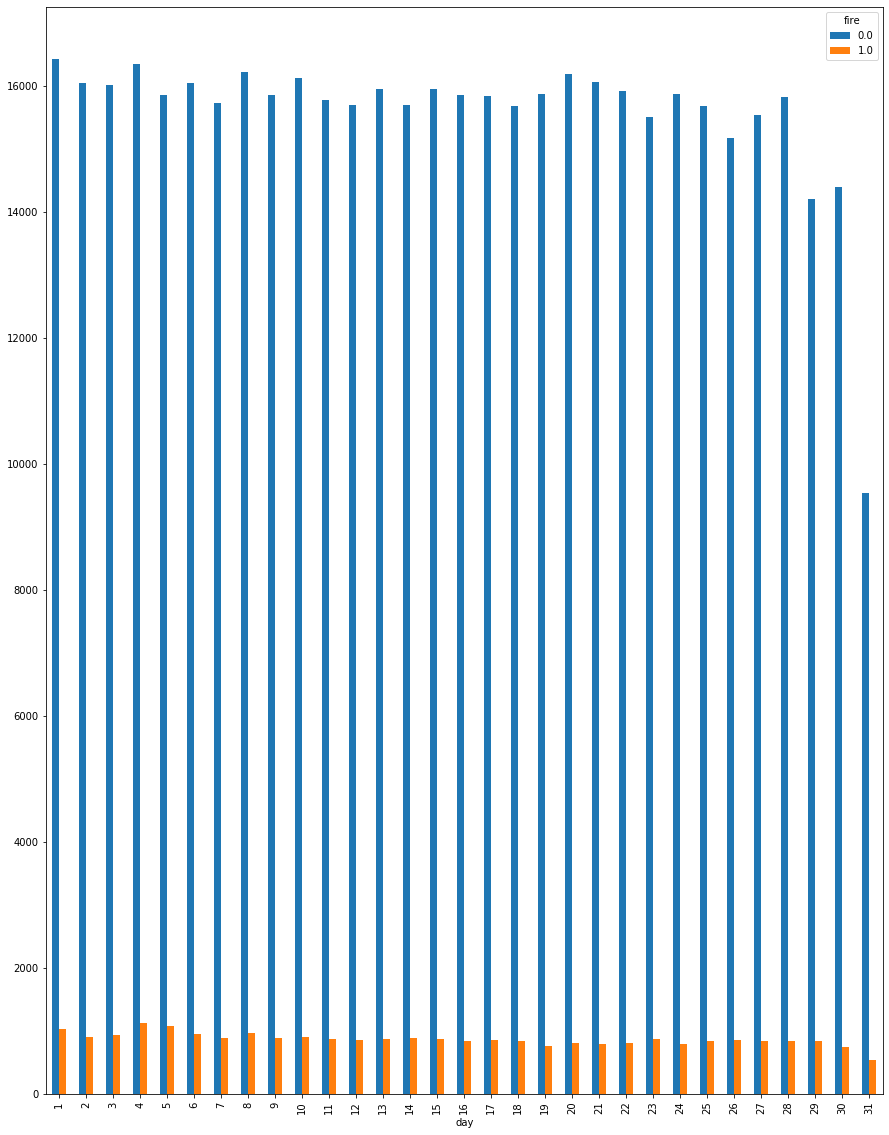

In [25]:
pd.crosstab(fire["day"],fire["fire"]).plot(kind='bar',figsize = (15,20))

Finally, count of fire incidents by day of week by actual fire occurances did not show enough variation to suggest that it would be a helpful predictor.

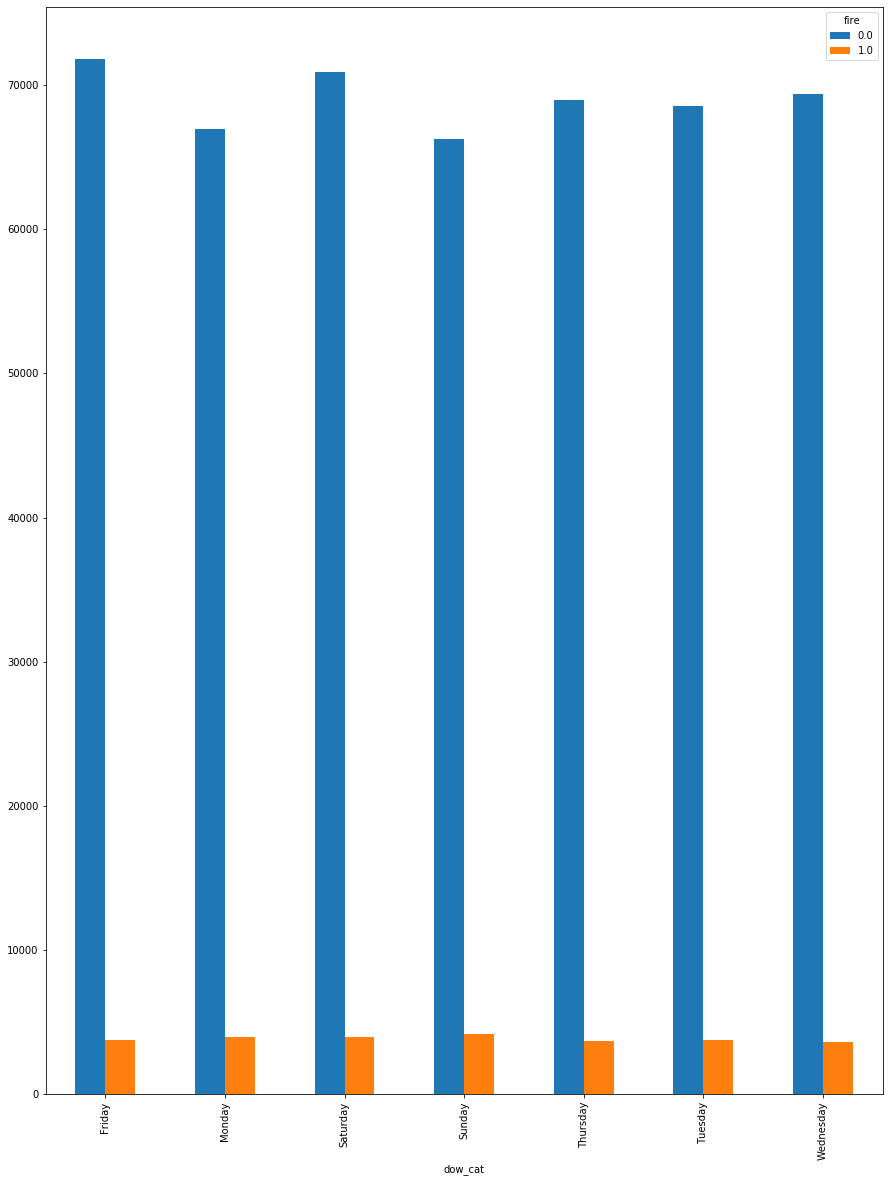

In [26]:
pd.crosstab(fire["dow_cat"],fire["fire"]).plot(kind='bar',figsize = (15,20))

For the next few boxplots, we look at the arrival_lag and duration variables, where arrival lag is the time it took to arrive the scene and duration is the time spend at the incident.

From the first box plot, we see that average arrival times have a smaller IQR range indicating less variation. This means that arrival times to the fire incident scenes are more consistent around the mean and indicate good response times by the fire deparments.


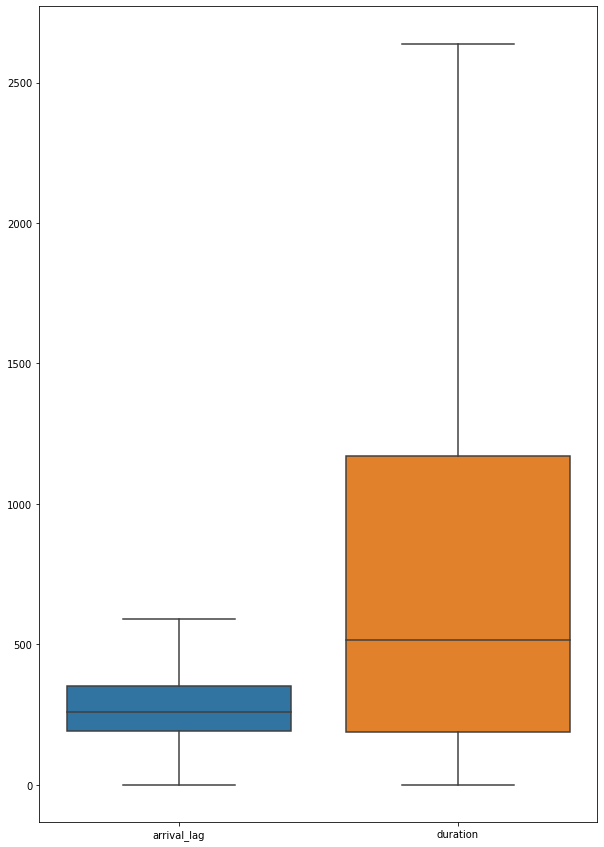

In [27]:
plt.figure(figsize = (10,15))
sns.boxplot(data=fire[["arrival_lag","duration"]], showfliers=False)

In the second plot of boxplots of arrival_lag by city by actual fire occurance, we see that arival times where a real fire has occured generally has a lower mean value than the mean arrival times for non-fire incidents. We also notice that for the cities AI and OAK there are no real fire incidents and arrival times are much greater in mean value and in range. This indicates that these two districts might actually be different cities (i.e. OAK = Oakland) and that responding to these regions requires significantly more time, perhaps due to the fact that they might not be the first fire deparment dispatched to that area. Brisbane and Hunters Point stand out as a city with higher overall mean values for arrival lag.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

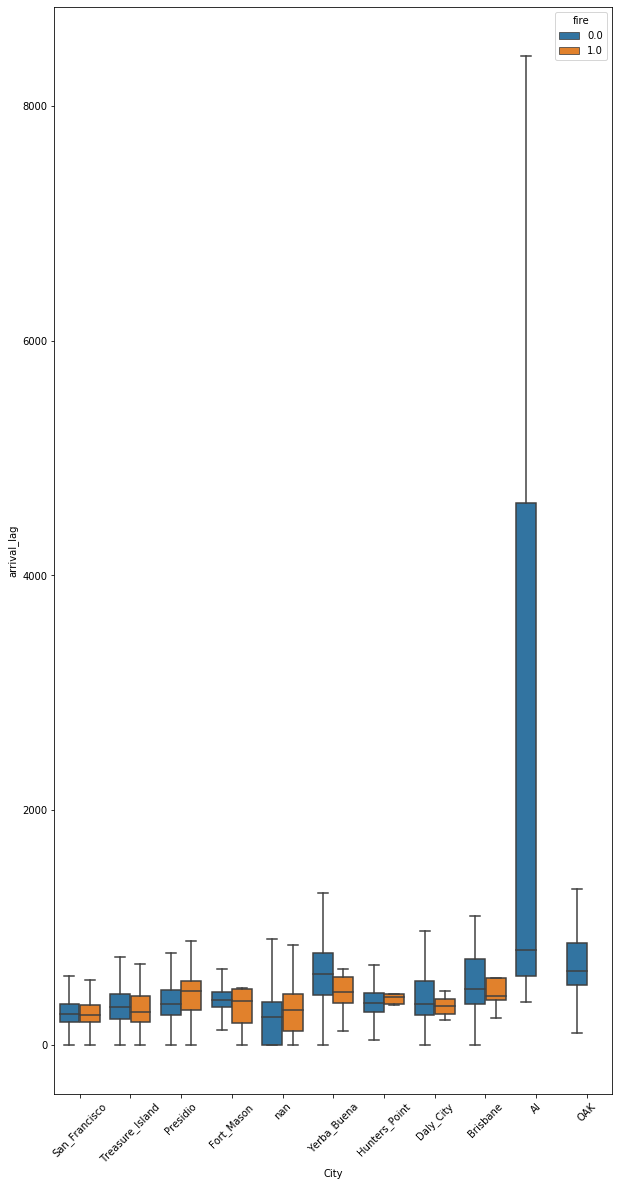

In [28]:
plt.figure(figsize = (10,20))
sns.boxplot(x= fire["City"], y=fire["arrival_lag"], hue=fire["fire"], showfliers=False)
plt.xticks(rotation=45)
#g.set_xticklabels(g.get_xticklabels(),rotation=30)

For the third plot of boxplots of duration by city by actual fire occurances, we see that incidents with real fires are far more time consuming with a much greater mean value than the mean value of duration for non-fire incidents. The large IQR also shows that incidents with real fires have much greater variation indicating how resource intensive real fire incidents are. Fort Mason stands out as having the highest mean duration for incidents where real fires occur.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

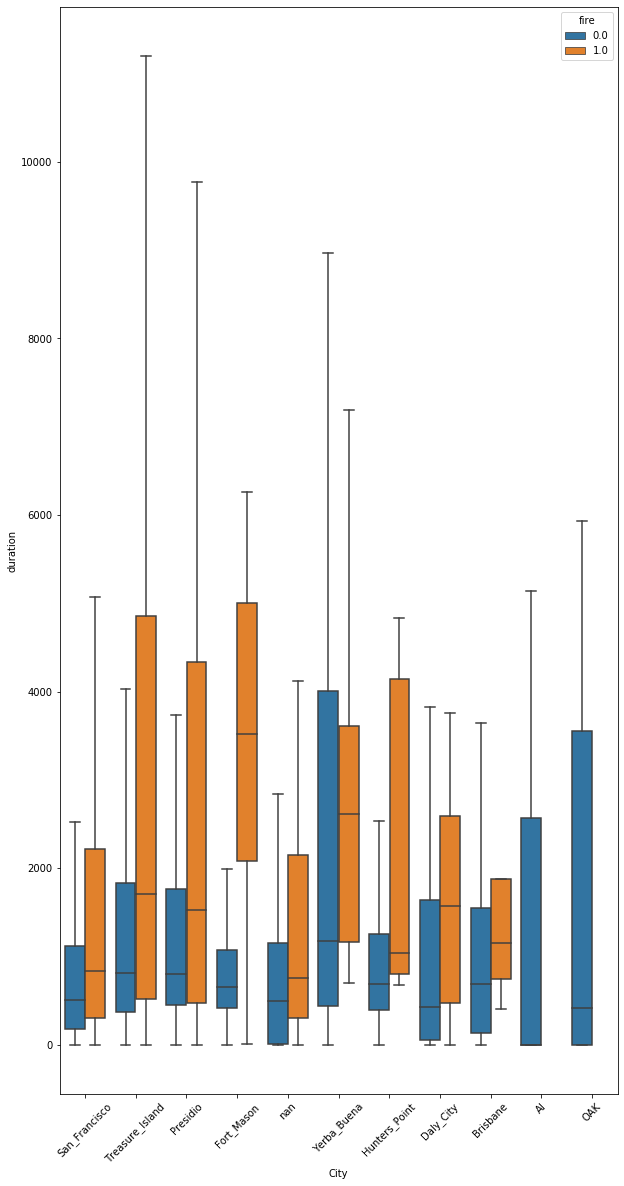

In [29]:
plt.figure(figsize = (10,20))
sns.boxplot(x= fire["City"], y=fire["duration"], hue=fire["fire"], showfliers=False)
plt.xticks(rotation=45)

## Task 2:The relationship between fire incidents and police reports

The data dictionaries for police incident reports 2018 to present and the data dictionary for the fire incidents were consulted to determine the relationship between the reports. It was determined that the field "Call Number" in the fire incidents dataset and the field "CAD Number" in the police report dataset both correspond to a unqiue 9 digit code issued by the Computer Aided Dispatch. This should be the common field between the two reports. However, when the two tables are joined together below, it was found that only 9 rows matched and the incidents do not seem to completely match.

Another problem identified is that the "CAD Number" field was only added to the 2018 to present dataset for police reports _(seen in dataset change notice)_. For the historical years of 2003 to May 2018, there is no such field to link the two tables. More work needs to be done to see whether or not the two fields actually match and if other linking fields are available to help link the data.


In [30]:
#load police data set
pl = pd.read_csv("police.csv")

#join fire and police
fire.merge(pl,"inner",left_on="Call Number", right_on="CAD Number")

,Incident Number_x,Exposure Number,Address,Incident Date_x,Call Number,Alarm DtTm,Arrival DtTm,Close DtTm,City,Zipcode,...,point,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,HSOC Zones as of 2018-06-05,OWED Public Spaces,Central Market/Tenderloin Boundary Polygon - Updated,Parks Alliance CPSI (27+TL sites),ESNCAG - Boundary File
0,19085531,0,Post Street,07/20/2019,192011664,2019-07-20 12:41:32,2019-07-20 12:45:21,2019-07-20 13:08:07,San_Francisco,94102.0,...,POINT (-122.41169923333719 37.78787216759232),50.0,6.0,3.0,21.0,NaN,NaN,NaN,NaN,NaN
1,18108108,0,Market,09/14/2018,182573333,2018-09-14 18:54:09,2018-09-14 18:59:47,2018-09-14 19:05:37,San_Francisco,94114.0,...,POINT (-122.472312257191 37.780655826818),5.0,8.0,4.0,29.0,NaN,3.0,NaN,NaN,NaN
2,19091674,0,1217 Ralston Avenue,08/04/2019,192160530,2019-08-04 05:44:28,2019-08-04 05:53:57,2019-08-04 06:06:37,Presidio,94129.0,...,POINT (-122.41625970692009 37.78537597388642),20.0,5.0,10.0,36.0,NaN,NaN,1.0,NaN,NaN
3,19057064,0,219 Ofarrell Street,05/14/2019,191343800,2019-05-14 21:36:38,2019-05-14 21:41:41,2019-05-14 21:50:41,San_Francisco,94102.0,...,POINT (-122.44598442613956 37.75235171503818),51.0,7.0,5.0,38.0,NaN,NaN,NaN,NaN,NaN
4,19081888,0,1 280sb,07/11/2019,191922853,2019-07-11 16:06:12,2019-07-11 16:08:49,2019-07-11 17:19:45,San_Francisco,94107.0,...,POINT (-122.39651523718821 37.73715618359288),87.0,2.0,9.0,1.0,NaN,NaN,NaN,NaN,NaN
5,18002368,0,0 Mission Street,01/06/2018,180060405,2018-01-06 03:27:45,2018-01-06 03:32:37,2018-01-06 03:32:50,San_Francisco,94103.0,...,POINT (-122.392661869673 37.766691459465),34.0,1.0,10.0,4.0,NaN,NaN,NaN,NaN,NaN
6,18002368,0,0 Mission Street,01/06/2018,180060405,2018-01-06 03:27:45,2018-01-06 03:32:37,2018-01-06 03:32:50,San_Francisco,94103.0,...,POINT (-122.392661869673 37.766691459465),34.0,1.0,10.0,4.0,NaN,NaN,NaN,NaN,NaN
7,18007734,0,0 Polk Street,01/18/2018,180182275,2018-01-18 14:49:38,2018-01-18 14:56:42,2018-01-18 15:01:29,San_Francisco,94103.0,...,POINT (-122.410951619088 37.784141011304),20.0,5.0,10.0,36.0,NaN,NaN,1.0,NaN,NaN
8,18046645,0,Post,04/20/2018,181100852,2018-04-20 08:25:01,2018-04-20 08:26:41,2018-04-20 08:40:43,San_Francisco,94109.0,...,POINT (-122.397176878512 37.729909882568),86.0,2.0,9.0,1.0,NaN,NaN,NaN,NaN,NaN


## Task 3a: Modelling for when fires will occur - Logit Model

In the first section of Task 3, I calibrated a logit model to help predict when fires would occur. Since we have a "fire" field that has a binary indicator for actual fire occurance, this makes it condusive towards using a logit model, which predicts binary outcomes.

Independent variables used are month, day, City, structure type and structure status. Month and day are used as a continuous variable since we can use them as ordinal variables. City, structure type and structure status are categorical variables, so they are converted to dummy variables with on category dropped as the base variable.

The coefficient table output is shown and the coefficients are then used to score the original dataset to show probabilities for fire occurances for each incident record. A probability threshold can be chosen empirically to help determine which future incidents should be considered high risk for real fires.


In [31]:
#create dummy variables for City, structure type and structure status
cities = pd.get_dummies(fire["City"], drop_first= True)
fire_lm_set = pd.concat([fire,cities],axis=1)

#additional dummy creation options for structure type and status
#cities = pd.get_dummies(fire["City"], drop_first= True)
#st = pd.get_dummies(fire["stype"],drop_first= True, prefix="stype")
#ss = pd.get_dummies(fire["s_status"],drop_first= True, prefix="s_status")



In [32]:
glm = smf.glm('fire ~ month + day + stype + s_status + Brisbane + Daly_City + Fort_Mason + Hunters_Point + OAK + Presidio + San_Francisco + Treasure_Island + Yerba_Buena'
                            , 
              data=fire_lm_set,  family=sm.families.Binomial(sm.families.links.logit)).fit()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
#logit model co-efficients and summary
glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   fire   No. Observations:               509740
Model:                            GLM   Df Residuals:                   509713
Model Family:                Binomial   Df Model:                           26
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -95668.
Date:                Sun, 27 Oct 2019   Deviance:                   1.9134e+05
Time:                        23:40:08   Pearson chi2:                 5.09e+05
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.1145      0.136    -22.841      0.000      -3.382      -2.847
stype[T.1]          1.6642      0.176      9.447      0.000       1.319       2.009
stype[T.2]          2.6768      0.247     10.823      0.000       2.192       3.162
stype[T.3]          2.9370      0.119     24.614      0.000       2.703       3.171
stype[T.4]          4.1728      1.156      3.610      0.000       1.908       6.438
stype[T.5]          2.2603      0.171     13.223      0.000       1.925       2.595
stype[T.6]          3.7130      0.248     14.998      0.000       3.228       4.198
stype[T.7]          3.2027      0.366      8.739      0.000       2.484       3.921
stype[T.8]          3.4241      0.298     11.509      0.000       2.841       4.007
s_status[T.1]       1.7815      0.241      7.393      0.000       1.309       2.254
s_status[T.2]       1.8604      0.175     10.618      0.000       1.517       2.204
s_status[T.3]       3.3069      0.398      8.313      0.000       2.527       4.087
s_status[T.4]       2.3825      0.289      8.251      0.000       1.817       2.948
s_status[T.5]       2.5255      0.247     10.208      0.000       2.041       3.010
s_status[T.6]       2.9032      0.300      9.683      0.000       2.316       3.491
s_status[T.7]       1.7612      0.896      1.966      0.049       0.005       3.517
month              -0.0233      0.002    -12.185      0.000      -0.027      -0.020
day                -0.0058      0.001     -7.698      0.000      -0.007      -0.004
Brisbane            1.0474      0.488      2.145      0.032       0.090       2.005
Daly_City           0.4190      0.358      1.171      0.242      -0.282       1.120
Fort_Mason         -0.6564      0.381     -1.723      0.085      -1.403       0.090
Hunters_Point      -0.7933      0.476     -1.667      0.095      -1.726       0.139
OAK               -20.2197   1.62e+04     -0.001      0.999   -3.18e+04    3.17e+04
Presidio           -0.3299      0.191     -1.726      0.084      -0.704       0.045
San_Francisco       0.2765      0.136      2.038      0.042       0.011       0.542
Treasure_Island     0.5557      0.169      3.287      0.001       0.224       0.887
Yerba_Buena        -0.1506      0.350     -0.431      0.667      -0.836       0.535
===================================================================================
"""

The original output is scored and a summary of the probabilities for the incidents is given.

In [34]:
#show probability for first 10 incident records
glm.predict(fire_lm_set).head(10)

0    0.046873
1    0.056235
2    0.042416
3    0.040364
4    0.044824
5    0.043373
6    0.042416
7    0.043364
8    0.044088
9    0.025093
dtype: float64

In [35]:
#prediction summary
glm.predict(fire_lm_set).describe()

count    5.097400e+05
mean     5.289952e-02
std      7.125504e-02
min      4.697891e-11
25%      4.102311e-02
50%      4.388270e-02
75%      4.716101e-02
max      9.796435e-01
dtype: float64

## Task 3b: Modelling for where fires will occur - Multinomial Logit Model

In this second section of task 3, I create a model to predict where fires will occur. The "City" field is used as the dependent variable as it provides a succinct set of categorical outcomes. The neighbourhood districts field has too many possible options as outputs and therefore, it is unlikely for one category to stand out greatly. The "San_Francisco" entries are also eliminated, as there are over 500 000 of these records, which makes the dataset biased completely to the San Francisco category. As well since San Francisco also seems like a generic label, it was removed to focus on the other city options possible. Future work can look into better encoding of the "San_Francisco" label. 

The final subset has 289 records, and the independent variables are month and day. Structure type and structure status were also considered, however as there only 289 records and most of those entries are 0, they did not improve the predictive power of the model at all and were subsequently dropped.

The final model uses Brisbane as the base city. A summary table of the coefficients and their p-values are given. The results of rolling out the model onto the original records is shown. The model provides 6 different outcome probabilities for an incident record. The outcome with the highest probability can be taken as the City where the fire is most likely to occur. 

In [36]:
mn_sub = fire.loc[(fire["fire"]==1) & (fire["City"]!='San_Francisco'),["month","day","City","stype","s_status"]]

In [37]:
x = sm.add_constant(mn_sub, prepend = False)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [38]:
x = x[["month","day","const"]]

In [39]:
mdl = sm.MNLogit(mn_sub["City"], x)

In [40]:
mdl_fit = mdl.fit()

Optimization terminated successfully.
         Current function value: 1.469060
         Iterations 7


In [41]:
#coefficient table
mdl_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                   City   No. Observations:                  289
Model:                        MNLogit   Df Residuals:                      268
Method:                           MLE   Df Model:                           14
Date:                Sun, 27 Oct 2019   Pseudo R-squ.:                 0.01966
Time:                        23:40:24   Log-Likelihood:                -424.56
converged:                       True   LL-Null:                       -433.07
Covariance Type:            nonrobust   LLR p-value:                    0.2546
==============================================================================
      City=Daly_City       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
month                    0.5326      0.203      2.627      0.009       0.135       0.930
day                      0.0620      0.064      0.965      0.335      -0.064       0.188
const                   -3.9033      1.800     -2.168      0.030      -7.431      -0.375
----------------------------------------------------------------------------------------
City=Fort_Mason       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
month               0.3079      0.195      1.581      0.114      -0.074       0.690
day                 0.0284      0.064      0.446      0.655      -0.096       0.153
const              -1.5910      1.582     -1.006      0.315      -4.692       1.510
-----------------------------------------------------------------------------------
City=Hunters_Point       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
month                  0.1410      0.218      0.647      0.518      -0.286       0.569
day                    0.0139      0.071      0.195      0.846      -0.126       0.154
const                 -0.8981      1.695     -0.530      0.596      -4.221       2.425
--------------------------------------------------------------------------------------
City=Presidio       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
month             0.2693      0.167      1.610      0.107      -0.059       0.597
day              -0.0078      0.052     -0.148      0.882      -0.110       0.095
const             1.1851      1.197      0.990      0.322      -1.161       3.531
---------------------------------------------------------------------------------
City=Treasure_Island       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
month                    0.2815      0.165      1.708      0.088      -0.042       0.605
day                     -0.0013      0.051     -0.026      0.979      -0.102       0.099
const                    1.7315      1.169      1.482      0.138      -0.559       4.022
----------------------------------------------------------------------------------------
City=Yerba_Buena       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
month                0.2141      0.191      1.121      0.262      -0.160       0.588
day                  0.0152      0.062      0.245      0.806      -0.106       0.136
const               -0.6457      1.473     -0.438      0.661      -3.533       2.242
------------------------------------------------------------------------------------
  City=nan       coef    std err          z      P>|z|      [0.025

In [42]:
#model prediction for incident records
mdl_fit.predict(x)

,0,1,2,3,4,5,6,7
1359,0.031419,0.006592,0.022660,0.023082,0.210062,0.406434,0.037551,0.262200
3037,0.011469,0.015809,0.025309,0.014012,0.232297,0.460005,0.030377,0.210721
4455,0.011521,0.042817,0.040026,0.017576,0.206109,0.452238,0.038883,0.190830
6374,0.008889,0.030271,0.031639,0.013590,0.224953,0.468619,0.031936,0.190103
6582,0.008888,0.034266,0.033485,0.013972,0.221481,0.467342,0.032917,0.187648
...,...,...,...,...,...,...,...,...
504386,0.019339,0.033773,0.041822,0.023852,0.194207,0.429389,0.045884,0.211734
506400,0.014596,0.007653,0.019409,0.014052,0.238424,0.445937,0.028068,0.231861
506759,0.005202,0.024427,0.024388,0.008927,0.247607,0.489424,0.023910,0.176115
508814,0.014596,0.007653,0.019409,0.014052,0.238424,0.445937,0.028068,0.231861


## Task 3: Limitations

There are a few limitations regarding logit and multinomial logit models that should be considered:

1.	The selection of independent variables is critical to the model’s predictive ability. The selection of independent variables was based on a quick exploratory analysis of the dataset. Additional understanding of fire incidents can help inform which additional features should be included into the regression models. Context specific knowledge is very important in facilitating the selection of useful independent variables.
<p>

2.	The regression models also assume that each individual record is independent to the next one. This may not be the case as certain incidents can be linked together through the exposure number. Exploratory analysis showed that this may not be an issue as most incidents seemed to be individual ones. 
<p>
3.	Overfitting or the overstating of the accuracy of the prediction is also a potential pitfall for logit and multinomial logit models. If there is sampling bias towards one group or another, this may lead to overfitting, where the model works very well with the data that is used to calibrate it, however, when external data is fed into the model, the accuracy drops significantly. The fire incidents dataset is heavily biased towards non-fire occurring incidents; therefore, this bias may be affecting the final model coefficients. A larger sample with less polarization in both the dependent variable and independent variables can be used to help address these problems.
<p>
4.	Multicollinearity or high correlation values among independent variables was not assessed. This is an important issue as including independent variables with high levels of multicollinearity can impact the coefficients and decrease the accuracy of the model. Different measures of correlation for categorical variables (ie. Biserial correlation, Spearman’s) can be used to assess correlation in future work.
<p>
5.	Finally, it should also be noted that the outcomes need to be categorical for both logit and multinomial logits. These models work when we are looking at discrete outcomes such as will a fire occur or not and which city will the fire most likely occur in?


## Task 4: Additional information regarding features in the dataset

There are a few additional aspects regarding the fire incident dataset that should be noted:

1.	The dataset holds a lot of sparse values, such as “Area of Origin” is not filled out for many of the incidents where a real fire has occurred.
<p>
    
2.	The data not consistent. For example, in the “address” field, different rows have different levels of address information. For the “City” field, abbreviations and capitalizations are used which results in multiple duplicate groups when aggregating. 
<p>
3.	For fields like “Primary Situation” and “Property Use” where there is a numeric code and a string description, the two elements should be separated into their own atomic fields. This will help with standardizing the descriptions and make the numeric codes more useful for classification
<p>
4.	Some fields such as “Area of Origin” and “Mutual Aid” contain uncleaned data with unnecessary strings such as “uu” and “n none” respectively. These additional characters make the data hard to summarize and make the fields inconsistent and invalid. They should be cleaned before further processing.
<p>
5.	There are also columns that are somewhat duplicate and the distinction is unclear. The “Neighbourhood District” column includes some of the cities from the “City” field, indicating that the categories in the City field are not necessarily distinct cities. These columns need to be reconciled and redundant ones deleted. If one is a subset of the other to create more analysis, it should be renamed and a mapping between categories should be clearly stated.
<p>
6.	Most of these features are also post-hoc features which are determined after a fire. For example, the number of EMS units and suppression units sent in can only be determined after a fire is determined to have broken out. If the dataset contained more information regarding the property or features known before hand, such as last maintenance, number of floors, date of construction, presence of flammable materials, temperature and distance to fire station, these can provide a greater set of relevant independent variables for the models.
<p>

# References
<p>
<li>https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.get_dummies.html
<li>https://docs.python.org/2/library/calendar.html
<li>https://docs.scipy.org/doc/
<li>https://pandas.pydata.org/pandas-docs/stable/
<li>https://seaborn.pydata.org/examples/index.html
<li>https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783
<li>https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry
<li>https://data.sfgov.org/Public-Safety/Fire-Incidents/wr8u-xric
<li>https://www.guru99.com/date-time-and-datetime-classes-in-python.html
<li>https://www.statsmodels.org/stable/example_formulas.html
<li>https://stackoverflow.com/questions/35131798/tweaking-seaborn-boxplot
<li>https://python-graph-gallery.com/30-basic-boxplot-with-seaborn/
<li>https://stackoverflow.com/questions/26540035/rotate-label-text-in-seaborn-factorplot/26540821
<li>https://intellipaat.com/community/21080/re-sub-erroring-with-expected-string-or-bytes-like-object
<li>https://machinelearning-blog.com/2018/04/23/logistic-regression-101/
<li>https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5543767/


## End of Analysis and Report